# `CNRatioAnomalyModel` Tutorial

Trey V. Wenger (c) August 2024

`CNRatioAnomalyModel` is like `CNRatioModel`, but allows for non-LTE variations in the 12CN hyperfine component optical depths, often called "hyperfine anomalies." We assume that 13CN does not suffer from similar effects. This notebook demonstrates this model and is otherwise nearly identical to the `CNRatioModel` notebook.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.5.0+6.g3c38c15
bayes_cn_hfs version: 0+untagged.1.g7eec682.dirty


In [2]:
# Get molecular data needed for simulating data
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
mol_data_13CN = get_molecule_data(
    "C-13-N", # molecule name in JPLSpec
    rot_state_lower = 0, # lower rotational state
)

## Simulating Data

Text(0, 0.5, '$T_{B,\\,^{13}\\rm CN}$ (K)')

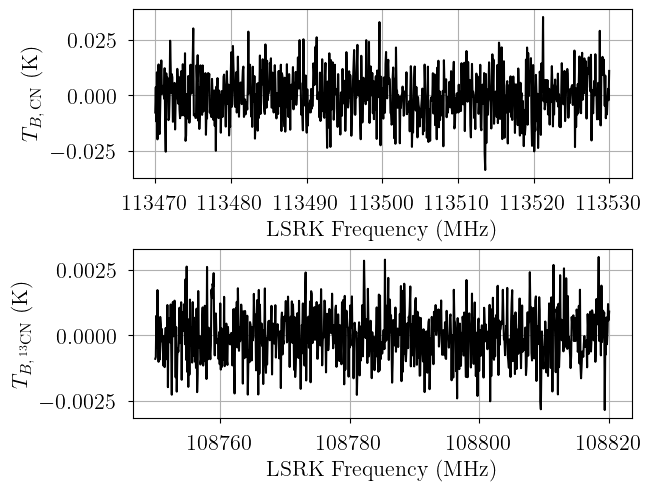

In [3]:
from bayes_spec import SpecData

# spectral axis definitions
freq_axis_12CN = np.linspace(113470, 113530, 825) # MHz
freq_axis_13CN = np.linspace(108750, 108820, 825)

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise_12CN = 0.01 # K
noise_13CN = 0.001 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN = noise_12CN * np.random.randn(len(freq_axis_12CN)) # K
brightness_data_13CN = noise_13CN * np.random.randn(len(freq_axis_13CN)) # K

# Our model only expects two observations named "12CN" and "13CN"
observation_12CN = SpecData(
    freq_axis_12CN,
    brightness_data_12CN,
    noise_12CN,
    xlabel="LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    brightness_data_13CN,
    noise_13CN,
    xlabel="LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
dummy_data = {"12CN": observation_12CN, "13CN": observation_13CN}

# Plot the dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["12CN"].spectral, dummy_data["12CN"].brightness, 'k-')
axes[1].plot(dummy_data["13CN"].spectral, dummy_data["13CN"].brightness, 'k-')
axes[0].set_xlabel(dummy_data["12CN"].xlabel)
axes[1].set_xlabel(dummy_data["13CN"].xlabel)
axes[0].set_ylabel(dummy_data["12CN"].ylabel)
axes[1].set_ylabel(dummy_data["13CN"].ylabel)

Text(0.02, 0.5, '$T_{B,\\,\\rm CN}$ (K)')

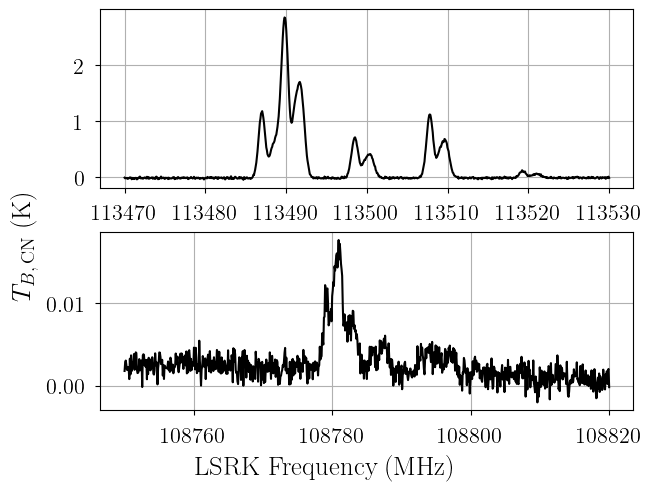

In [4]:
from bayes_cn_hfs import CNRatioAnomalyModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = CNRatioAnomalyModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 0.2], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_temp = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_nonthermal_fwhm = 1.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_rms_12CN = 0.01, # width of the 12CN spectral rms prior (K)
    prior_rms_13CN = 0.01, # width of the 13CN spectral rms prior (K)
    prior_baseline_coeffs_12CN = [1.0, 1.0, 1.0], # width of polynomial baseline coefficients prior
    prior_baseline_coeffs_13CN = [1.0, 1.0, 1.0], # width of polynomial baseline coefficients prior
    prior_hyperfine_anomaly_12CN = 0.1, # width of the 12CN hyperfine anomaly prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

hyperfine_anomaly_12CN = np.ones((len(mol_data_12CN['freq']), n_clouds))
hyperfine_anomaly_12CN[6] = 0.75
hyperfine_anomaly_12CN[7] = 1.25

sim_params = {
    "log10_N_12CN": [14.0, 13.5, 14.2],
    "log10_temp": [1.0, 1.2, 1.1],
    "nonthermal_fwhm": [3.0, 2.0, 2.5],
    "velocity": [-2.0, 0.0, 3.0],
}
sim_params_12CN = sim_params.copy()
sim_params_12CN.update({
    "hyperfine_anomaly_12CN": hyperfine_anomaly_12CN,
    "rms_12CN": noise_12CN,
    "12CN_baseline_norm": [-1.0, 0.5, 3.0], # normalized baseline coefficients
})
sim_params_13CN = sim_params.copy()
sim_params_13CN.update({
    "ratio_13C_12C": [0.01, 0.02, 0.005],
    "rms_13CN": noise_13CN,
    "13CN_baseline_norm": [2.0, -2.0, -3.0], # normalized baseline coefficients
})

sim_brightness_12CN = model.model["12CN"].eval(sim_params_12CN)
sim_brightness_13CN = model.model["13CN"].eval(sim_params_13CN)

# Plot the dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["12CN"].spectral, sim_brightness_12CN, 'k-')
axes[1].plot(dummy_data["13CN"].spectral, sim_brightness_13CN, 'k-')
fig.supxlabel(dummy_data["12CN"].xlabel)
fig.supylabel(dummy_data["12CN"].ylabel)

In [5]:
# Now we pack the simulated spectra into a new SpecData instance
observation_12CN = SpecData(
    freq_axis_12CN,
    sim_brightness_12CN,
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    sim_brightness_13CN,
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
data = {"12CN": observation_12CN, "13CN": observation_13CN}

## Model Definition

In [6]:
# Initialize and define the model
model = CNRatioAnomalyModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 0.2], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_temp = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_nonthermal_fwhm = 1.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_rms_12CN = 0.01, # width of the 12CN spectral rms prior (K)
    prior_rms_13CN = 0.01, # width of the 13CN spectral rms prior (K)
    prior_baseline_coeffs_12CN = [1.0, 1.0, 1.0], # width of polynomial baseline coefficients prior
    prior_baseline_coeffs_13CN = [1.0, 1.0, 1.0], # width of polynomial baseline coefficients prior
    prior_hyperfine_anomaly_12CN = 0.1, # width of the 12CN hyperfine anomaly prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

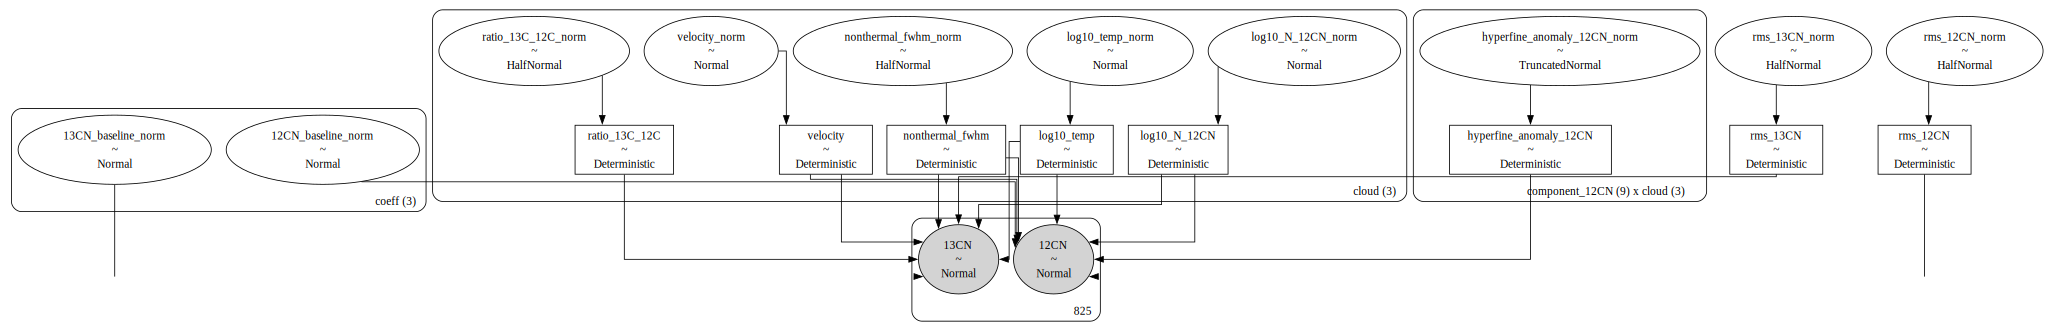

In [7]:
# Plot model graph
model.graph().render('cn_ratio_anomaly_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

         12CN_baseline_norm ~ Normal(0, <constant>)
         13CN_baseline_norm ~ Normal(0, <constant>)
          log10_N_12CN_norm ~ Normal(0, 1)
            log10_temp_norm ~ Normal(0, 1)
       nonthermal_fwhm_norm ~ HalfNormal(0, 1)
              velocity_norm ~ Normal(0, 1)
         ratio_13C_12C_norm ~ HalfNormal(0, 1)
              rms_12CN_norm ~ HalfNormal(0, 1)
              rms_13CN_norm ~ HalfNormal(0, 1)
hyperfine_anomaly_12CN_norm ~ TruncatedNormal(0, 1, -10, inf)
               log10_N_12CN ~ Deterministic(f(log10_N_12CN_norm))
                 log10_temp ~ Deterministic(f(log10_temp_norm))
            nonthermal_fwhm ~ Deterministic(f(nonthermal_fwhm_norm))
                   velocity ~ Deterministic(f(velocity_norm))
              ratio_13C_12C ~ Deterministic(f(ratio_13C_12C_norm))
                   rms_12CN ~ Deterministic(f(rms_12CN_norm))
                   rms_13CN ~ Deterministic(f(rms_13CN_norm))
     hyperfine_anomaly_12CN ~ Deterministic(f(hyperfine_anomaly_1

Sampling: [12CN, 12CN_baseline_norm, 13CN, 13CN_baseline_norm, hyperfine_anomaly_12CN_norm, log10_N_12CN_norm, log10_temp_norm, nonthermal_fwhm_norm, ratio_13C_12C_norm, rms_12CN_norm, rms_13CN_norm, velocity_norm]


array([[<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>],
       [<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,^{13}\\rm CN}$ (K)'>]],
      dtype=object)

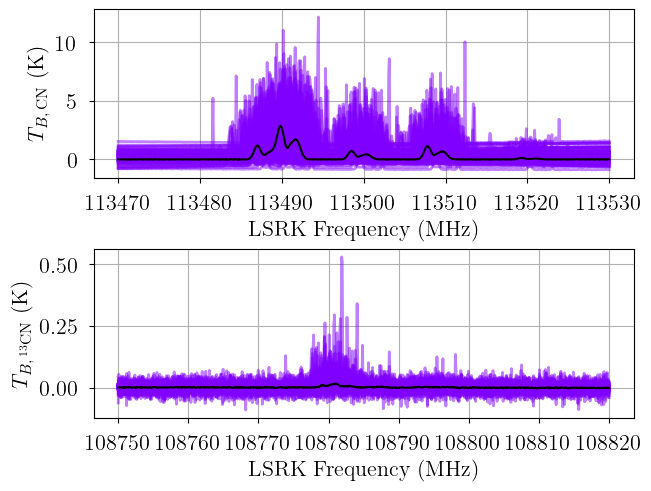

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5700
Interrupted at 5,699 [5%]: Average Loss = 79,987


Runtime: 2.45 minutes


In [11]:
# posterior samples stored in model.trace.posterior
pm.summary(model.trace.posterior, var_names=model.deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N_12CN[0],14.064,0.002,14.061,14.067,0.000,0.000,637.0,901.0,NaN
log10_N_12CN[1],13.893,0.003,13.887,13.898,0.000,0.000,966.0,880.0,NaN
log10_N_12CN[2],13.947,0.002,13.943,13.952,0.000,0.000,873.0,1013.0,NaN
log10_temp[0],0.944,0.003,0.939,0.951,0.000,0.000,1073.0,943.0,NaN
log10_temp[1],0.977,0.021,0.934,1.012,0.001,0.000,997.0,1026.0,NaN
log10_temp[2],0.921,0.020,0.881,0.956,0.001,0.000,885.0,864.0,NaN
nonthermal_fwhm[0],2.199,0.007,2.187,2.213,0.000,0.000,1009.0,950.0,NaN
nonthermal_fwhm[1],5.499,0.037,5.423,5.563,0.001,0.001,998.0,878.0,NaN
nonthermal_fwhm[2],3.164,0.014,3.140,3.192,0.000,0.000,1007.0,737.0,NaN
velocity[0],3.098,0.004,3.090,3.105,0.000,0.000,988.0,961.0,NaN


Sampling: [12CN, 13CN]


Output()

array([[<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>],
       [<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,^{13}\\rm CN}$ (K)'>]],
      dtype=object)

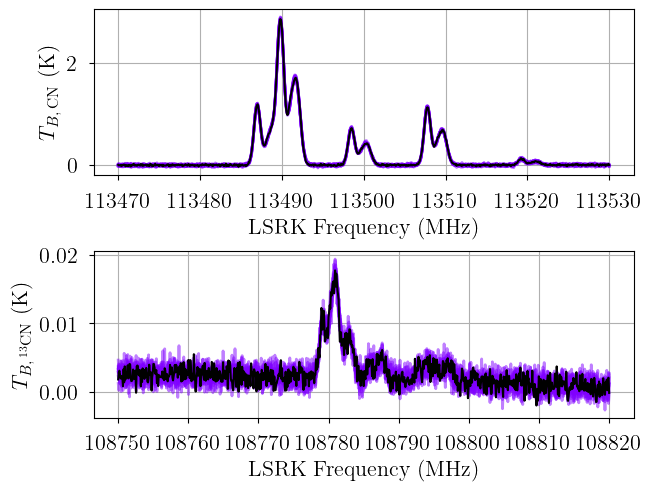

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

This model takes a long time to sample...

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5700
Interrupted at 5,699 [5%]: Average Loss = 79,987
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [12CN_baseline_norm, 13CN_baseline_norm, log10_N_12CN_norm, log10_temp_norm, nonthermal_fwhm_norm, velocity_norm, ratio_13C_12C_norm, rms_12CN_norm, rms_13CN_norm, hyperfine_anomaly_12CN_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5156 seconds.


Runtime: 87.94 minutes


In [14]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [15]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N_12CN[0],14.195,0.015,14.166,14.223,0.000,0.000,1603.0,2215.0,1.0
log10_N_12CN[1],13.428,0.036,13.360,13.496,0.001,0.001,1866.0,2025.0,1.0
log10_N_12CN[2],14.016,0.022,13.978,14.060,0.001,0.000,1858.0,1651.0,1.0
log10_temp[0],1.075,0.021,1.037,1.115,0.000,0.000,2556.0,2585.0,1.0
log10_temp[1],1.026,0.072,0.894,1.159,0.001,0.001,2986.0,2146.0,1.0
log10_temp[2],1.050,0.056,0.950,1.159,0.001,0.001,2343.0,1534.0,1.0
nonthermal_fwhm[0],2.491,0.011,2.472,2.512,0.000,0.000,2477.0,2747.0,1.0
nonthermal_fwhm[1],1.988,0.050,1.896,2.085,0.001,0.001,1904.0,2196.0,1.0
nonthermal_fwhm[2],3.016,0.028,2.959,3.067,0.001,0.000,2106.0,1859.0,1.0
velocity[0],2.995,0.003,2.990,3.000,0.000,0.000,3045.0,2701.0,1.0


Sampling: [12CN, 13CN]


Output()

array([[<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>],
       [<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,^{13}\\rm CN}$ (K)'>]],
      dtype=object)

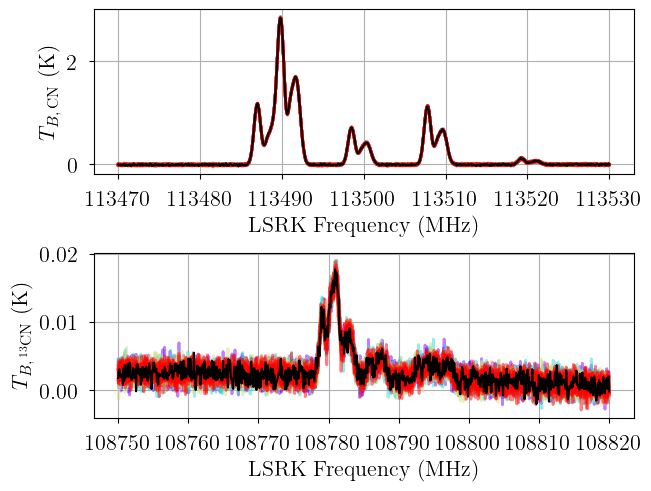

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'log10_N_12CN_norm'}>,
        <Axes: title={'center': 'log10_N_12CN_norm'}>],
       [<Axes: title={'center': 'log10_temp_norm'}>,
        <Axes: title={'center': 'log10_temp_norm'}>],
       [<Axes: title={'center': 'nonthermal_fwhm_norm'}>,
        <Axes: title={'center': 'nonthermal_fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'ratio_13C_12C_norm'}>,
        <Axes: title={'center': 'ratio_13C_12C_norm'}>],
       [<Axes: title={'center': 'hyperfine_anomaly_12CN_norm'}>,
        <Axes: title={'center': 'hyperfine_anomaly_12CN_norm'}>],
       [<Axes: title={'center': '12CN_baseline_norm'}>,
        <Axes: title={'center': '12CN_baseline_norm'}>],
       [<Axes: title={'center': '13CN_baseline_norm'}>,
        <Axes: title={'center': '13CN_baseline_norm'}>],
       [<Axes: title={'center': 'rms_12CN_norm'}>,
        <Axes: title={'center': 'rms_12CN

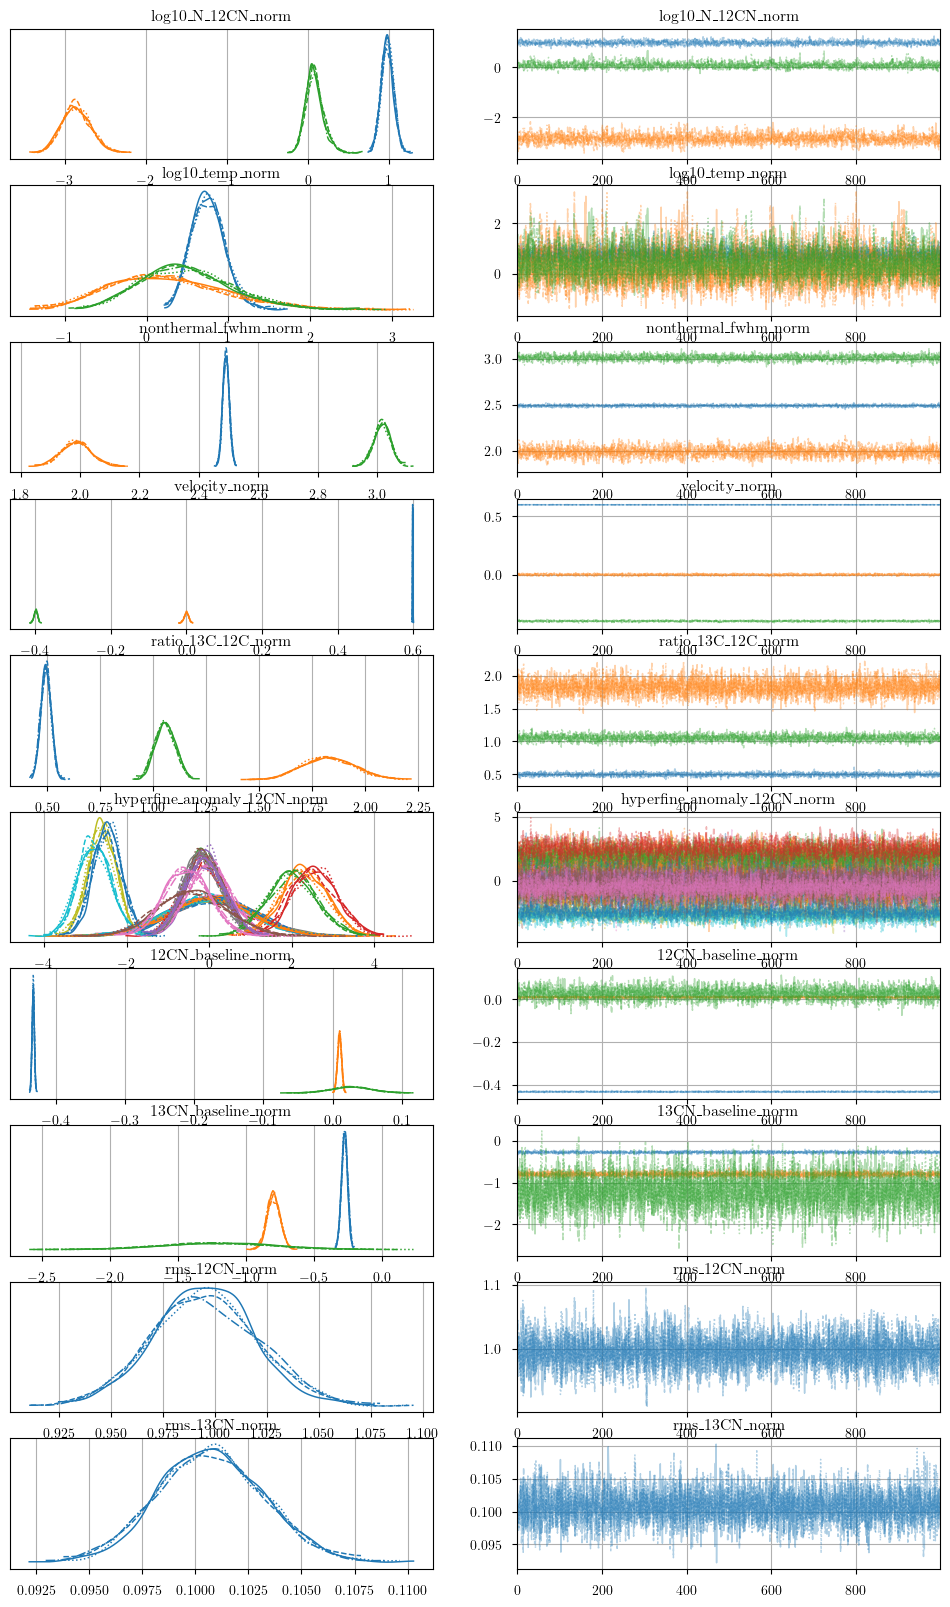

In [17]:
from bayes_spec.plots import plot_traces

plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log10_temp_norm'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='nonthermal_fwhm_norm'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='velocity_norm'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='log10_N_12CN_norm', ylabel='ratio_13C_12C_norm'>,
        <Axes: xlabel='log10_temp_norm'>,
        <Axes: xlabel='nonthermal_fwhm_norm'>,
        <Axes: xlabel='velocity_norm'>,
        <Axes: xlabel='ratio_13C_12C_norm'>]], dtype=object)

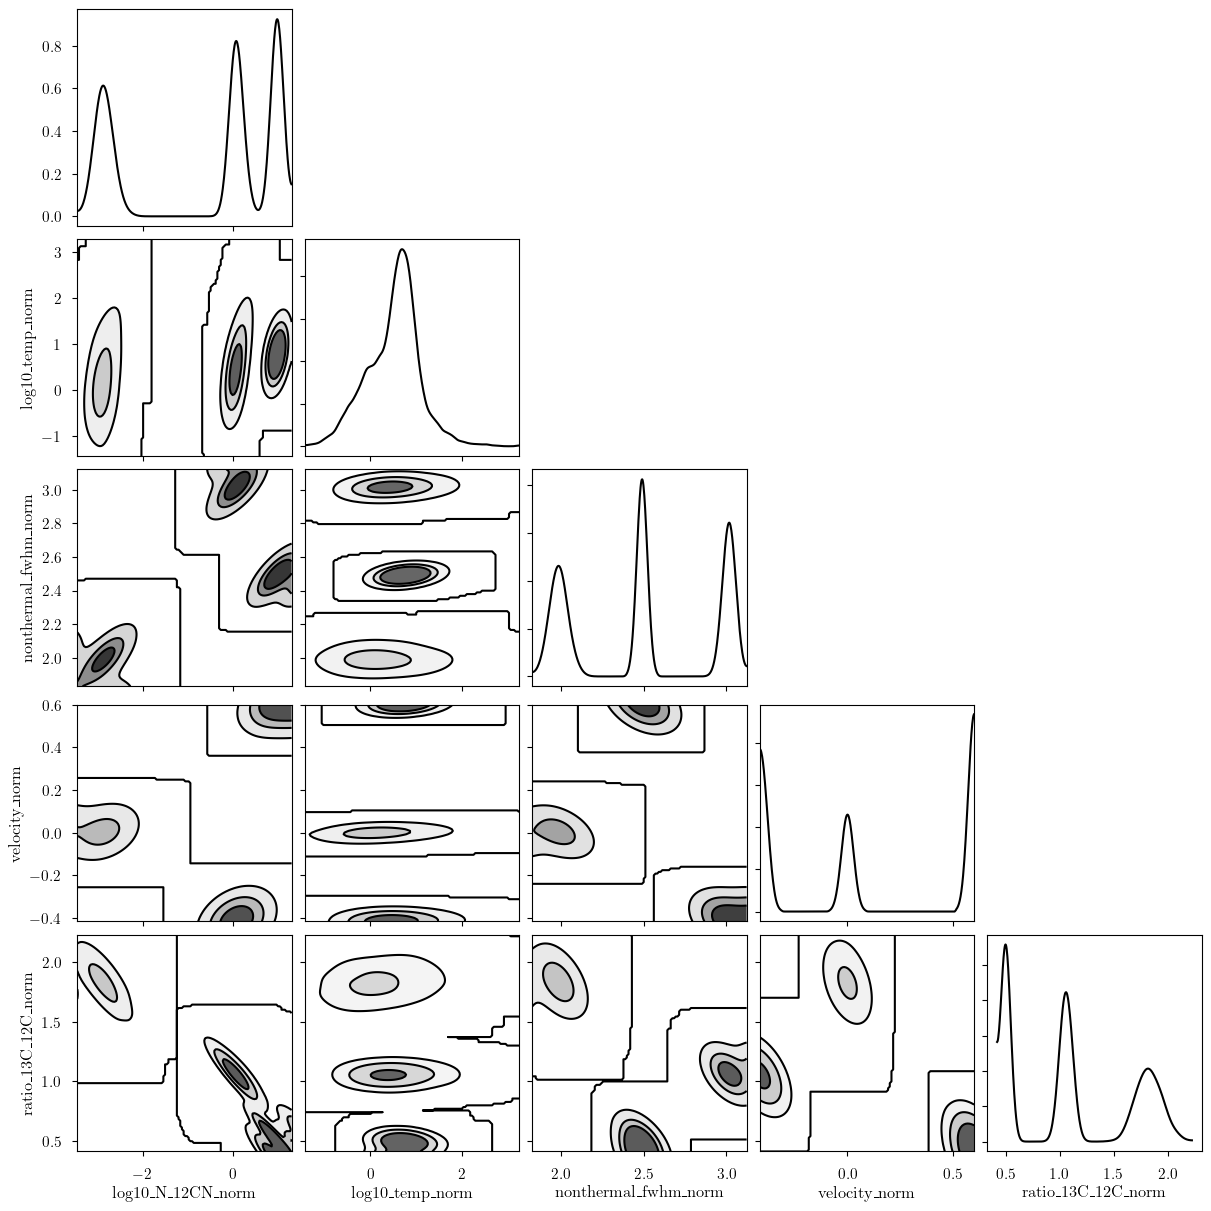

In [18]:
from bayes_spec.plots import plot_pair

var_names = [var_name for var_name in model.cloud_params if var_name not in ["hyperfine_anomaly_12CN_norm"]]
plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log$_{10}$ $T$ (K)'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='$\\Delta V_{\\rm nt}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$v_{\\rm LSR}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='log$_{10}$ $N_{\\rm CN}$ (cm$^{-2}$)', ylabel='$^{13}{\\rm C}/^{12}{\\rm C}$'>,
        <Axes: xlabel='log$_{10}$ $T$ (K)'>,
        <Axes: xlabel='$\\Delta V_{\\rm nt}$ (km s$^{-1}$)'>,
        <Axes: xlabel='$v_{\\rm LSR}$ (km s$^{-1}$)'>,
        <Axes: xlabel='$^{13}{\\rm C}/^{12}{\\rm C}$'>]], dtype=object)

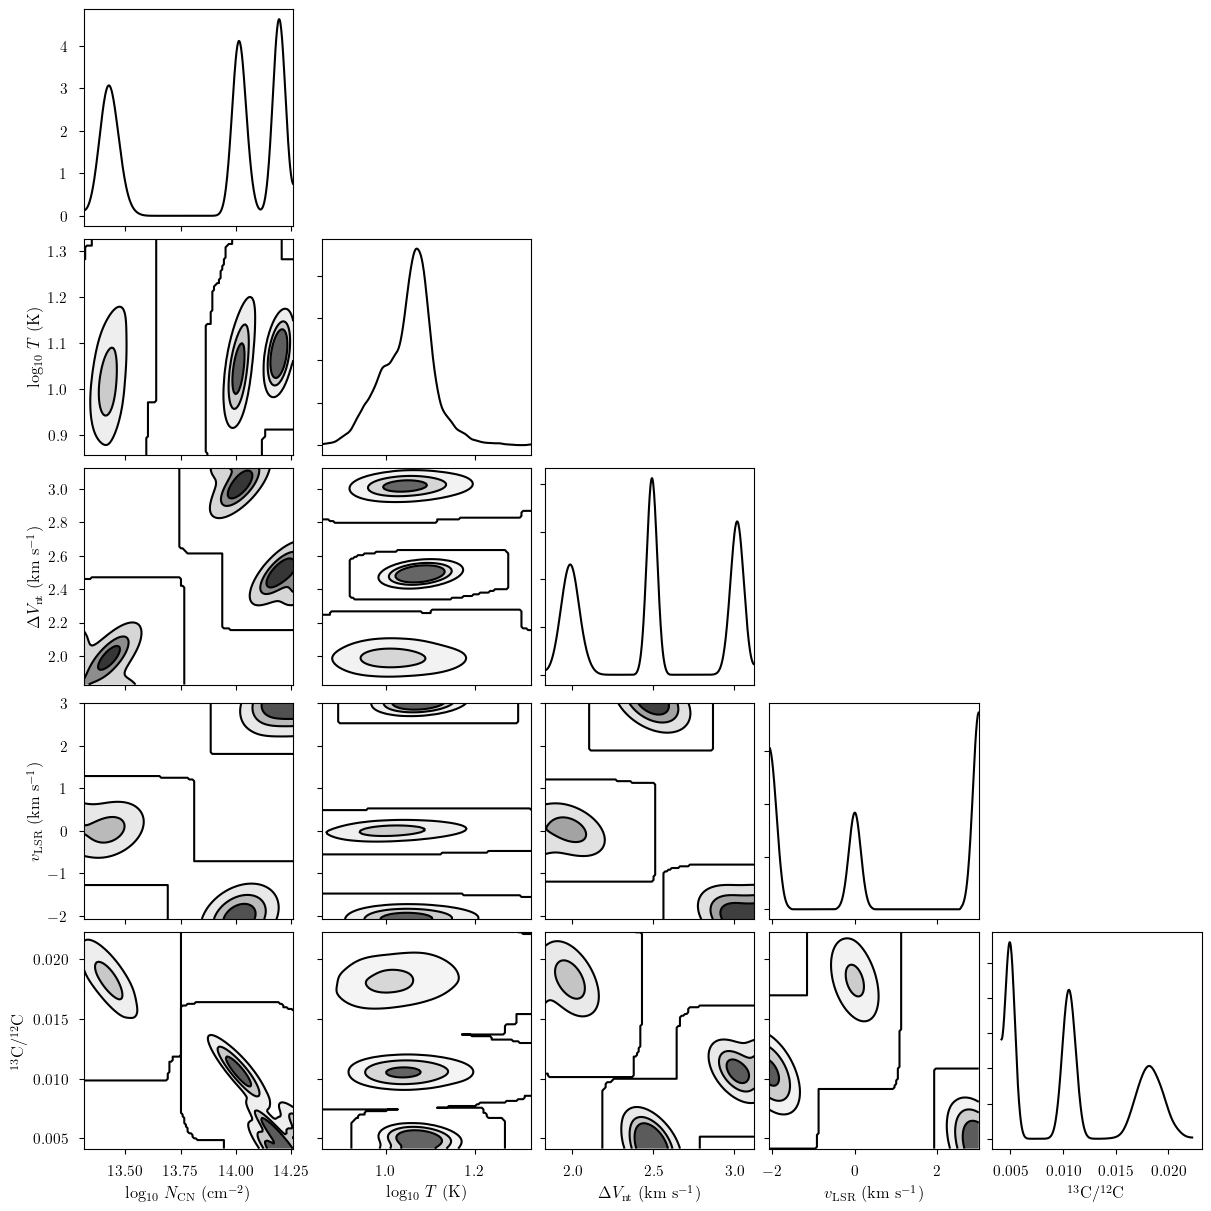

In [19]:
var_names = [var_name for var_name in model.deterministics if var_name not in ["rms_12CN", "rms_13CN", "hyperfine_anomaly_12CN"]]
plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [20]:
point_stats = az.summary(model.trace.solution_0, var_names=model.deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -14068.04783947702


,mean,sd,hdi_16%,hdi_84%
log10_N_12CN[0],14.195,0.015,14.180,14.210
log10_N_12CN[1],13.428,0.036,13.389,13.460
log10_N_12CN[2],14.016,0.022,13.991,14.032
log10_temp[0],1.075,0.021,1.054,1.094
log10_temp[1],1.026,0.072,0.945,1.084
log10_temp[2],1.050,0.056,0.992,1.101
nonthermal_fwhm[0],2.491,0.011,2.480,2.501
nonthermal_fwhm[1],1.988,0.050,1.937,2.033
nonthermal_fwhm[2],3.016,0.028,2.988,3.043
velocity[0],2.995,0.003,2.992,2.997


In [22]:
az.summary(model.trace.solution_0, var_names=["hyperfine_anomaly_12CN"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"hyperfine_anomaly_12CN[113123.3687, 0]",1.008,0.096,0.832,1.187,0.002,0.001,3340.0,2939.0,1.0
"hyperfine_anomaly_12CN[113123.3687, 1]",1.021,0.095,0.848,1.201,0.001,0.001,4419.0,2968.0,1.0
"hyperfine_anomaly_12CN[113123.3687, 2]",1.011,0.094,0.828,1.181,0.001,0.001,4622.0,3084.0,1.0
"hyperfine_anomaly_12CN[113144.19, 0]",1.008,0.094,0.835,1.183,0.001,0.001,3939.0,2873.0,1.0
"hyperfine_anomaly_12CN[113144.19, 1]",1.018,0.095,0.828,1.188,0.001,0.001,4302.0,2237.0,1.0
"hyperfine_anomaly_12CN[113144.19, 2]",1.010,0.094,0.821,1.174,0.001,0.001,4351.0,2477.0,1.0
"hyperfine_anomaly_12CN[113170.535, 0]",1.006,0.094,0.827,1.181,0.002,0.001,3452.0,3121.0,1.0
"hyperfine_anomaly_12CN[113170.535, 1]",1.020,0.097,0.828,1.193,0.001,0.001,5118.0,2974.0,1.0
"hyperfine_anomaly_12CN[113170.535, 2]",1.007,0.097,0.837,1.197,0.002,0.001,4042.0,2457.0,1.0
"hyperfine_anomaly_12CN[113191.325, 0]",1.005,0.092,0.830,1.173,0.002,0.001,3783.0,2529.0,1.0
